In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, mean_squared_error, f1_score, precision_recall_curve, auc
#from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay


from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression




In [2]:

# Load the survey data
MH_SURVEY = pd.read_csv("./Datasets/open_icpr/Input/MentalHealthSurvey/Mental_Health_Survey_Feb_20_22.csv")

# Not actual survey
MH_SURVEY = MH_SURVEY[MH_SURVEY['Status'] != "Survey Preview"]

# Only people who finished
MH_SURVEY = MH_SURVEY[MH_SURVEY['Finished'] == 'TRUE']

# Remove non-full time students
MH_SURVEY = MH_SURVEY[MH_SURVEY['fulltime'] == "Yes"]

# Only one fails attention check
MH_SURVEY = MH_SURVEY[MH_SURVEY['attention'] == "Turquoise"]

# Remove wrong response
MH_SURVEY = MH_SURVEY[(MH_SURVEY['feedback'].isna()) |
                      (MH_SURVEY['feedback'] != "I accidentally clicked one of the questions in the section for if I had said 'yes' to being diagnosed with depression - sorry!")]

variables_to_drop = ['StartDate',
                    'EndDate',
                    'Duration (in seconds)',
                    'RecordedDate',
                    'ResponseId', 
                    'ProlificID',
                    'BrowserInfo_Browser',
                    'BrowserInfo_Version',
                    'BrowserInfo_Operating System',
                     'BrowserInfo_Resolution',
                     'surveys',
                     'timing_phq9_First Click', 
                     'timing_phq9_Last Click',
                    'timing_phq9_Page Submit', 
                     'timing_phq9_Click Count', 
                    'timing_intro_First Click',
                    'timing_intro_Last Click',
                    'timing_intro_Page Submit',
                    'timing_intro_Click Count',
                     'timing_gad7_First Click',
                     'timing_gad7_Last Click',
                     'timing_gad7_Page Submit',
                     'timing_gad7_Click Count',
                    'timing_consent_First Click',
                    'timing_consent_Last Click',
                    'timing_consent_Page Submit',
                    'timing_consent_Click Count',
                     'timing_mh_intro_First Click',
                    'timing_mh_intro_Last Click',
                    'timing_mh_intro_Page Submit',
                    'timing_mh_intro_Click Count',
                    'timing_controls_First Click',
                    'timing_controls_Last Click',
                    'timing_controls_Page Submit',
                    'timing_controls_Click Count',
                     'acha_part2_timing_First Click', 'acha_part2_timing_Last Click',
                       'acha_part2_timing_Page Submit', 'acha_part2_timing_Click Count',
                     'acha_timing_First Click',
                   'acha_timing_Last Click', 'acha_timing_Page Submit',
                   'acha_timing_Click Count',
                    'purpose',
                    'feedback',
                    'timing_feedback_First Click',
                    'timing_feedback_Last Click',
                    'timing_feedback_Page Submit',
                    'timing_feedback_Click Count',
                    'PROLIFIC_PID',
                     'state_1',
                     "Status", "Progress", "Finished", "DistributionChannel", "UserLanguage", 
                  "survey_intro", "Create New Field or Choose From Dropdown...",
                  "FL_11_DO_PHQ-9", "FL_11_DO_GAD-7", "FL_11_DO_ACHA",
                     'attention'
                     ]


# Drop unused columns
MH_SURVEY = MH_SURVEY.drop(columns=variables_to_drop)


In [3]:

# *************************************************************************
#  RENAME ----
# *************************************************************************

# .PHQ-9 ----
# .........................................................................

phqNames = MH_SURVEY.filter(regex='^phq9_').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(phqNames, 
    ["phq9_interest", "phq9_depressed", "phq9_sleep", "phq9_tired", "phq9_appetite",
     "phq9_failure", "phq9_concentrating", "phq9_speed", "phq9_selfharm"])))

# .GAD7 ----
# .........................................................................

gad = MH_SURVEY.filter(regex='^gad7_').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(gad, 
    ["gad7_anxious", "gad7_control", "gad7_worrying", "gad7_relaxing", 
     "gad7_restless", "gad7_annoyed", "gad7_afraid"])))

# .ACHA ----
# .........................................................................

# How many times in past year
achaNames12Month_times = MH_SURVEY.filter(regex='^acha_12months_times').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(achaNames12Month_times, 
    ["acha_12months_times_hopeless", "acha_12months_times_overwhelmed", "acha_12months_times_exhausted", 
     "acha_12months_times_sad", "acha_12months_times_depressed", "acha_12months_times_considerSuicide", 
     "acha_12months_times_attemptSuicide"])))

# Have you suffered in last year
achaNames12Month_any = MH_SURVEY.filter(regex='^acha_12months_any').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(achaNames12Month_any, 
    ["acha_12months_any_allergy", "acha_12months_any_anorexia", "acha_12months_any_anxiety", "acha_12months_any_asthma", 
     "acha_12months_any_bulimia", "acha_12months_any_fatigure", "acha_12months_any_depression", "acha_12months_any_diabetes", 
     "acha_12months_any_endometriosi", "acha_12months_any_herpes", "acha_12months_any_hpv", "acha_12months_any_hepatitis", 
     "acha_12months_any_blood", "acha_12months_any_cholesterol", "acha_12months_any_HIV", "acha_12months_any_stressInjury", 
     "acha_12months_any_seasonal", "acha_12months_any_substance", "acha_12months_any_back", "acha_12months_any_fracture", 
     "acha_12months_any_bronchitis", "acha_12months_any_chlamydia", "acha_12months_any_ear", "acha_12months_any_gonorrhea", 
     "acha_12months_any_mononucleosis", "acha_12months_any_pelvic", "acha_12months_any_sinus", "acha_12months_any_strep", 
     "acha_12months_any_tuberculosis"])))

# Depression services
services = MH_SURVEY.filter(regex='^acha_services').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(services, 
    ["acha_services_dianosed", "acha_services_therapy", "acha_services_medication"])))

# race
race = MH_SURVEY.filter(regex='^race_').columns
MH_SURVEY = MH_SURVEY.rename(columns=dict(zip(race, 
    ["race_white", "race_black", "race_hispanic", "race_asian", "race_native", "race_other"])))

# Convert categorical responses to numerical values

# Label encoding for ordinal data
ordinal_columns = {
    'general_health': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
    'phq9_interest': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_depressed': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_sleep': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_tired': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_appetite': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_failure': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_concentrating': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_speed': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'phq9_selfharm': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_anxious': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_control': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_worrying': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_relaxing': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_restless': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_annoyed': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'gad7_afraid': ['Not at all', 'Several days', 'More than half of the days', 'Nearly every day'],
    'acha_12months_times_hopeless': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_overwhelmed': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_exhausted': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_sad': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_depressed': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_considerSuicide': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times'],
    'acha_12months_times_attemptSuicide': ['Never', '1-2 times', '3-4 times', '5-6 times', '7-8 times', '9-10 times', '11 or more times']
}

for col, categories in ordinal_columns.items():
    le = LabelEncoder()
    le.fit(categories)
    MH_SURVEY[col] = le.transform(MH_SURVEY[col])

# One-hot encoding for nominal data
nominal_columns = ['sex', 'international', 'race_white', 'race_black', 'race_hispanic', 'race_asian', 'race_native', 'race_other']

MH_SURVEY = pd.get_dummies(MH_SURVEY, columns=nominal_columns)

# Binary encoding for Yes/No columns
binary_columns = ['fulltime', 'acha_12months_any_allergy', 'acha_12months_any_anorexia',
                  'acha_12months_any_bulimia', 'acha_12months_any_fatigure', 'acha_depression', 'acha_services_dianosed', 
                  'acha_services_therapy', 'acha_services_medication', 'fulltime', 
                    'acha_12months_any_anxiety', 'acha_12months_any_depression']

binary_columns_to_drop = ['acha_12months_any_asthma', 'acha_12months_any_diabetes', 'acha_12months_any_endometriosi','acha_12months_any_herpes','acha_12months_any_hpv','acha_12months_any_hepatitis','acha_12months_any_blood',
                  'acha_12months_any_cholesterol','acha_12months_any_HIV','acha_12months_any_stressInjury','acha_12months_any_seasonal',
                  'acha_12months_any_substance','acha_12months_any_back','acha_12months_any_fracture','acha_12months_any_bronchitis',
                  'acha_12months_any_chlamydia','acha_12months_any_ear','acha_12months_any_gonorrhea','acha_12months_any_mononucleosis',
                  'acha_12months_any_pelvic','acha_12months_any_sinus','acha_12months_any_strep','acha_12months_any_tuberculosis']

for col in binary_columns:
    MH_SURVEY[col] = MH_SURVEY[col].map({'Yes': 1, 'No': 0})

MH_SURVEY.drop(columns=binary_columns_to_drop, inplace=True)


bool_columns = ['sex_Female', 'sex_Male', 'international_No', 'international_Yes', 'race_white_White - not Hispanic (includes Middle Eastern)',
                'race_black_Black - not Hispanic', 'race_hispanic_Hispanic or Latino', 'race_asian_Asian or Pacific Islander',
                'race_native_American Indian or Alaskan Native', 'race_other_Other']


for col in bool_columns:
    MH_SURVEY[col] = MH_SURVEY[col].astype(int)



# Drop rows with NaN values
#MH_SURVEY = MH_SURVEY.dropna()


# Calculate total score
score_columns = [
    'phq9_interest', 'phq9_depressed', 'phq9_sleep', 'phq9_tired', 'phq9_appetite',
    'phq9_failure', 'phq9_concentrating', 'phq9_speed', 'phq9_selfharm',
    'gad7_anxious', 'gad7_control', 'gad7_worrying', 'gad7_relaxing', 
    'gad7_restless', 'gad7_annoyed', 'gad7_afraid',
    'acha_depression', 'acha_services_dianosed', 'acha_services_therapy', 'acha_services_medication', 'fulltime', 
    'acha_12months_any_anxiety', 'acha_12months_any_depression', 
    'acha_12months_times_hopeless', 'acha_12months_times_overwhelmed', 
    'acha_12months_times_exhausted', 'acha_12months_times_sad', 
    'acha_12months_times_depressed', 'acha_12months_times_considerSuicide', 
    'acha_12months_times_attemptSuicide'
]





MH_SURVEY['total_score'] = MH_SURVEY[score_columns].sum(axis=1)
MH_SURVEY.drop(columns=score_columns, inplace=True)

MH_SURVEY.drop(columns=['year_1'], inplace=True)



# Save the cleaned and encoded data
MH_SURVEY.to_csv("./Datasets/open_icpr/Intermediate/mhSurvey.csv")
MH_SURVEY

,general_health,acha_12months_any_allergy,acha_12months_any_anorexia,acha_12months_any_bulimia,acha_12months_any_fatigure,sex_Female,sex_Male,international_No,international_Yes,race_white_White - not Hispanic (includes Middle Eastern),race_black_Black - not Hispanic,race_hispanic_Hispanic or Latino,race_asian_Asian or Pacific Islander,race_native_American Indian or Alaskan Native,race_other_Other,total_score
2,2,0,0,0,0,1,0,1,0,1,0,0,0,0,0,69.0
3,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,64.0
4,4,0,0,0,0,1,0,1,0,0,0,0,1,0,0,47.0
5,2,1,0,0,0,1,0,1,0,1,0,0,0,0,0,46.0
6,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,4,0,0,0,0,0,1,1,0,1,0,0,0,0,0,71.0
578,4,0,0,0,0,0,1,1,0,0,0,0,0,0,1,67.0
579,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,56.0
580,2,0,0,0,1,0,1,1,0,1,0,0,1,0,0,70.0


In [4]:
avg = MH_SURVEY['total_score'].mean()
score_idx = MH_SURVEY.columns.get_loc('total_score')
print(avg)

for index, row in MH_SURVEY.iterrows():
    mental_status = row[score_idx]
    score = 'total_score'
    if mental_status > avg:
        MH_SURVEY.at[index, score] = 1
    else:
        MH_SURVEY.at[index, score] = 0

MH_SURVEY['total_score']

54.146153846153844


/var/folders/vx/3_43vh0d5f918xvnc_z59dh40000gn/T/ipykernel_87187/2948605038.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mental_status = row[score_idx]


2      1.0
3      1.0
4      0.0
5      0.0
6      0.0
      ... 
577    1.0
578    1.0
579    1.0
580    1.0
582    1.0
Name: total_score, Length: 520, dtype: float64

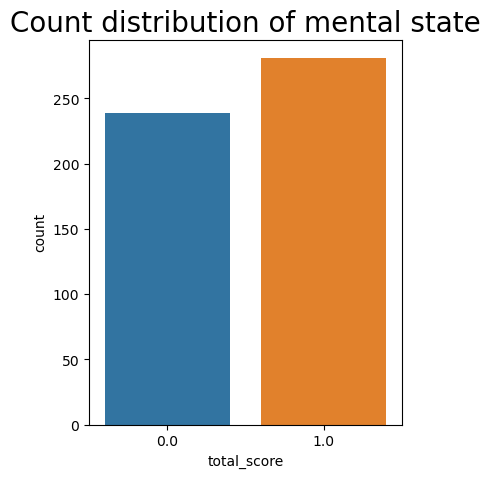

In [5]:
plt.figure(figsize=(5, 5), facecolor='w')
plt.subplots_adjust(right=1.5)
plt.subplot(121)
sns.countplot(x="total_score", data=MH_SURVEY)
plt.title("Count distribution of mental state", size=20)
#plt.subplot(122)
labels=[0,1]
#plt.pie(df2["mental_disorder"].value_counts().values,autopct="%1.1f%%",labels=labels,colors=["lime","red"])
plt.show()

In [6]:
# Separate features and labels
X = MH_SURVEY.drop('total_score', axis=1)
features = X.columns
y = MH_SURVEY['total_score']
print(y)
print(X.shape, y.shape)

2      1.0
3      1.0
4      0.0
5      0.0
6      0.0
      ... 
577    1.0
578    1.0
579    1.0
580    1.0
582    1.0
Name: total_score, Length: 520, dtype: float64
(520, 15) (520,)


In [7]:
MH_SURVEY

,general_health,acha_12months_any_allergy,acha_12months_any_anorexia,acha_12months_any_bulimia,acha_12months_any_fatigure,sex_Female,sex_Male,international_No,international_Yes,race_white_White - not Hispanic (includes Middle Eastern),race_black_Black - not Hispanic,race_hispanic_Hispanic or Latino,race_asian_Asian or Pacific Islander,race_native_American Indian or Alaskan Native,race_other_Other,total_score
2,2,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1.0
3,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1.0
4,4,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0.0
5,2,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0.0
6,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,4,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1.0
578,4,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1.0
579,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1.0
580,2,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1.0


In [8]:
# Separate features and labels

def get_predictors(df, pred_id):

    X = df.drop(pred_id, axis=1)
    y = df[pred_id]
    print(X.shape, y.shape)

    feature_names = X.columns
    
    X = X.astype(float).values
    y = y.astype(float).values
    print(X.shape)
    print(y.shape)

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
           
    return feature_names, X_train, X_test, y_train, y_test, feature_names
    
    # 0: no diagnosis

In [9]:
#pred_id = 'General_Mental'
pred_id = 'total_score'
#MH_SURVEY.drop(columns=['General_Mental'], inplace=True)
features, X_train, X_test, y_train, y_test, feature_names = get_predictors(MH_SURVEY, pred_id)

(520, 15) (520,)
(520, 15)
(520,)


In [10]:
# Assuming X_train, y_train, X_test, and y_test are predefined
# y_train and y_test have values of 1 (presence of mental issue) and 0 (no mental issue)

#pred_id = 'General_Mental'
#pred_id = 'Total_Score'
#features, X_train, X_test, y_train, y_test, feature_names = get_predictors(pd_data, pred_id)
# Ensure input arrays are 2D where expected
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)


#clf = RandomForestClassifier(max_depth=2, random_state=42)
classes = np.unique(y_test)

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "LogisticRegression",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(solver="liblinear", random_state=0),
]

# Perform PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate each classifier
best_score = 0
best_clf = None
best_name = ""
for name, clf in zip(names, classifiers):
    print(name)
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #y_proba = clf.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} F1: {f1:.4f}')
    
    score = clf.score(X_test, y_test)
    print(f"{name}: {score:.2f}")
    if score > best_score:
        best_score = score
        best_clf = clf
        best_name = name
    if name == 'Random Forest':
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        feature_importances = clf.feature_importances_
        
        indices = np.argsort(feature_importances)[::-1]
        #print("\nFeature ranking:")
        #for f in range(X_train.shape[1]):
            #print(f"{f + 1}. Feature {indices[f]} ({feature_importances[indices[f]]:.2f})")
        

print(f"\nBest performing model: {best_name} with a score of {best_score:.2f}")


    

Nearest Neighbors
Nearest Neighbors Accuracy: 0.5577
Nearest Neighbors F1: 0.5587
Nearest Neighbors: 0.56
Linear SVM
Linear SVM Accuracy: 0.6058
Linear SVM F1: 0.5509
Linear SVM: 0.61
RBF SVM
RBF SVM Accuracy: 0.5000
RBF SVM F1: 0.4974
RBF SVM: 0.50
Gaussian Process
Gaussian Process Accuracy: 0.5865
Gaussian Process F1: 0.5798
Gaussian Process: 0.59
Decision Tree
Decision Tree Accuracy: 0.5385
Decision Tree F1: 0.5053
Decision Tree: 0.54
Random Forest
Random Forest Accuracy: 0.5385
Random Forest F1: 0.5385
Random Forest: 0.54
Neural Net
Neural Net Accuracy: 0.5577
Neural Net F1: 0.5577
Neural Net: 0.56
AdaBoost
AdaBoost Accuracy: 0.5769
AdaBoost F1: 0.5747
AdaBoost: 0.58
Naive Bayes
Naive Bayes Accuracy: 0.5769
Naive Bayes F1: 0.5731
Naive Bayes: 0.58
LogisticRegression
LogisticRegression Accuracy: 0.5288
LogisticRegression F1: 0.5255
LogisticRegression: 0.53

Best performing model: Linear SVM with a score of 0.61


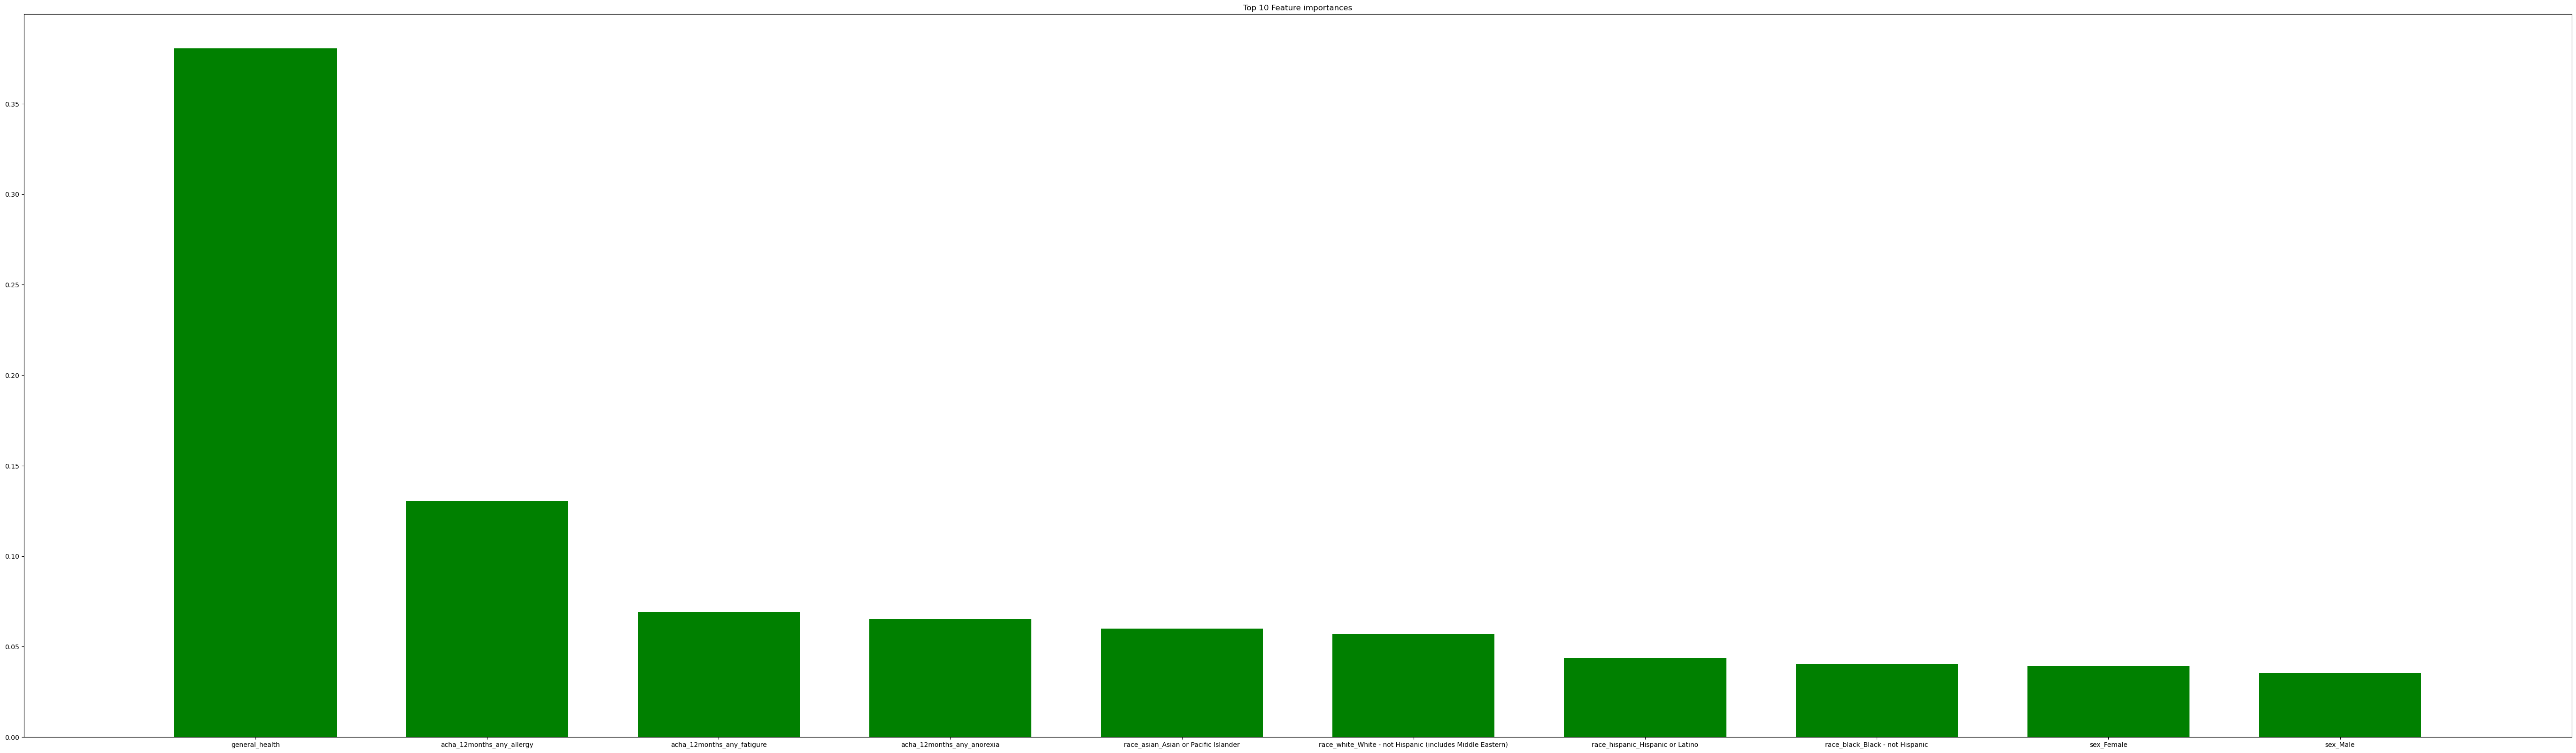

In [11]:
top_features = indices[:20]
color = 'green'
feature_names = []
for feat in top_features:
    feature_names.append(MH_SURVEY.columns[feat])
    
plt.figure(figsize=(70, 20))
plt.title("Top 10 Feature importances")
plt.bar(range(10), feature_importances[top_features][:10], color=color, align="center", width=0.7)
plt.xticks(range(10), feature_names[:10])
plt.xlim([-1, 10])
plt.show()



